In [1]:
import pandas as pd
import pandasql
from pandasql import sqldf
from datetime import date

save_result = 1

In [2]:
#numrows=1073769
colnm=['CMTE_ID','AMNDT_IND','RPT_TP','TRANSACTION_PGI','IMAGE_NUM','TRANSACTION_TP','ENTITY_TP','NAME','CITY','STATE',
       'ZIP_CODE','EMPLOYER','OCCUPATION','TRANSACTION_DT','TRANSACTION_AMT','OTHER_ID','TRAN_ID','FILE_NUM','MEMO_CD',
       'MEMO_TEXT','SUB_ID'
]
coltypes = {'CMTE_ID': str, 'AMNDT_IND':str, 'RPT_TP':str, 'TRANSACTION_PGI':str, 'IMAGE_NUM':str, 'TRANSACTION_TP':str, 
            'ENTITY_TP':str,'NAME':str, 'CITY':str, 'STATE':str, 'ZIP_CODE':str, 'EMPLOYER':str, 'OCCUPATION':str, 
            'TRANSACTION_DT':str, 'TRANSACTION_AMT':float, 'OTHER_ID':str, 'TRAN_ID':str, 'FILE_NUM':str, 'MEMO_CD':str, 
            'MEMO_TEXT':str, 'SUB_ID':str
           }
data_addit = pd.read_csv(r"../raw data/oth14/itoth2014.txt", 
                    sep='|', header=None, names = colnm, dtype=coltypes)

In [3]:
print(data_addit.shape)
data_addit.head()

(570489, 21)


CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM TRANSACTION_TP  \
0  C00177436         N     M3               P  13961108066            24K   
1  C00177436         N     M3             NaN  13961108067            24K   
2  C00177436         N     M3               P  13961108067            24K   
3  C00177436         N     M3               P  13961108067            24K   
4  C00177436         N     M3               P  13961108068            24K   

  ENTITY_TP                    NAME        CITY STATE  ... EMPLOYER  \
0       CCM    TIM SCOTT FOR SENATE  CHARLESTON    SC  ...      NaN   
1       COM     BOEHNER FOR SPEAKER  WASHINGTON    DC  ...      NaN   
2       CCM    TIM SCOTT FOR SENATE  CHARLESTON    SC  ...      NaN   
3       CCM  FRIENDS OF JIM CLYBURN    COLUMBIA    SC  ...      NaN   
4       CCM  FRIENDS FOR HARRY REID   LAS VEGAS    NV  ...      NaN   

  OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID   TRAN_ID FILE_NUM  \
0        NaN       02142013          2500.0  C00540302  35804463   858918   
1        NaN       02152013         10000.0  C00478354  35805813   858918   
2        NaN       02182013          2500.0  C00540302  35823277   858918   
3        NaN       02212013          1500.0  C00255562  35831821   858918   
4        NaN       02212013          2500.0  C00204370  35831833   858918   

  MEMO_CD MEMO_TEXT               SUB_ID  
0     NaN       NaN  4030420131184959063  
1     NaN       NaN  4030420131184959064  
2     NaN       NaN  4030420131184959065  
3     NaN       NaN  4030420131184959066  
4     NaN       NaN  4030420131184959067  

[5 rows x 21 columns]

In [4]:
# Check if there are any negative values for image_num, there shouldn't be for 2008
# If the below returns true, then there is a problem because there a negative values for image_num
any(data_addit['IMAGE_NUM'].str[0]=='-')
# Okay note to self, can't convert the image_num to integers because there's letters in the image_num sometimes.

False

Okay now I'm going to filter it and save only the ones with transaction_pgi containing 2020 into their own dataframe.

In [7]:
explicitly_incycle_data_addit = data_addit[data_addit['TRANSACTION_PGI'].str.contains("2016", na=False)]

In [8]:
explicitly_incycle_data_addit

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
284595  C90011578         N     Q3           G2016  14978174341   

       TRANSACTION_TP ENTITY_TP                               NAME  \
284595            24E       ORG  NATIONAL MEDIA PUBLIC AFFAIRS LLC   

              CITY STATE  ... EMPLOYER OCCUPATION TRANSACTION_DT  \
284595  ALEXANDRIA    VA  ...      NaN        NaN       08072014   

       TRANSACTION_AMT   OTHER_ID     TRAN_ID FILE_NUM MEMO_CD MEMO_TEXT  \
284595        179987.0  S6GA00119  F57.000002   956012     NaN       NaN   

                     SUB_ID  
284595  4101620141226094475  

[1 rows x 21 columns]

Using the election cycle dates, find any transaction that's not marked as in the election cycle but should be, and add those as well.
    I might have to do some extra research on how early before an election cycle starts, transactions can be made that count towards that.
* So, for the 2020 file, I will use the fact that the 2020 election cycle was [11-7-2018, 11-3-2020] and extract any transactions that (have a transaction_pgi containing 2020) OR (11-7-2018 <= transaction_dt <= 11-3-2020).
    * This is assuming that the dates in itoth2020 are actually from 2019 to 2020...I know from analyzing some of the other data that there are some weird records with like year 0 or year that's way later than it should be the data file.
    * Improvement Idea 1) a): Come back and investigate these weird dates, and decide what to do with them. For now, I'll just ignore them and not include them in my dataset.
    * Improvement Idea 1) b): Make sure that transactions for an election cycle can't take place before or after the election cycle dates...more of a boundary case
For now, I'll discard itoth2020.txt after I extract the 2020 election cycle. 
I can always redownload it from the FEC if I want to add in more records or do the 2020 election cycle, but rn it's taking up a lot of space on my computer.

In [9]:
data_addit[['TRANSACTION_DT']] = pd.to_datetime(data_addit['TRANSACTION_DT'], format='%m%d%Y').dt.date

Improvement Idea 1) d): Visualize the distribution of dates by histogramming it by years, then months for each year, then months, and days

In [10]:
data_addit[['TRANSACTION_DT']]

TRANSACTION_DT
0          2013-02-14
1          2013-02-15
2          2013-02-18
3          2013-02-21
4          2013-02-21
...               ...
570484     2014-11-03
570485     2014-11-03
570486     2014-11-03
570487     2014-11-12
570488     2014-11-17

[570489 rows x 1 columns]

In [12]:
startcyc = date(2014,11,5) #11-5-2014
endcyc = date(2016,11,8) #11-8-2016

In [13]:
#greater than the start date and smaller than the end date
mask = (data_addit['TRANSACTION_DT'] >= startcyc) & (data_addit['TRANSACTION_DT'] <= endcyc)
dates_in_2016cyc_fr2014 = data_addit.loc[mask]
dates_in_2016cyc_fr2014

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI           IMAGE_NUM  \
88968   C00008086         A     YE               G         14960497814   
90630   C00468579         A     YE               G         14960866185   
113515  C00458463         A     Q2               G         13020322083   
220941  C00010421         A    30G               G         14953206796   
220942  C00010421         A    30G               R         14953206796   
...           ...       ...    ...             ...                 ...   
570473  C00003418         A    30G             NaN  201510149002882039   
570477  C00003418         A    30G             NaN  201510149002882040   
570478  C00003418         A    30G             NaN  201510149002882041   
570487  C00003418         A    30G               P  201510149002881995   
570488  C00003418         A    30G               P  201510149002881996   

       TRANSACTION_TP ENTITY_TP                           NAME  \
88968             15J       IND                     POOLE, LEE   
90630             15J       IND                GOGUEN, MICHAEL   
113515            15J       IND              TIMKEN, WARD J JR   
220941            24K       CCM            ROGERS FOR CONGRESS   
220942            24K       CCM     BILL CASSIDY FOR US SENATE   
...               ...       ...                            ...   
570473            24C       ORG             TARRANCE GROUP INC   
570477            24C       ORG           SMARTECH CORPORATION   
570478            24C       ORG           SMARTECH CORPORATION   
570487            24G       PTY          UTAH REPUBLICAN PARTY   
570488            24G       PTY  REPUBLICAN PARTY OF LOUISIANA   

                  CITY STATE  ...                EMPLOYER  \
88968          BOZEMAN    MT  ...   MOONLIGHT BASIN RANCH   
90630        LOS ALTOS    CA  ...          PROOF RESEARCH   
113515          CANTON    OH  ...  THE TIMKEN CORPORATION   
220941        BRIGHTON    MI  ...                     NaN   
220942     BATON ROUGE    LA  ...                     NaN   
...                ...   ...  ...                     ...   
570473      ALEXANDRIA    VA  ...                     NaN   
570477     CHATTANOOGA    TN  ...                     NaN   
570478     CHATTANOOGA    TN  ...                     NaN   
570487  SALT LAKE CITY    UT  ...                     NaN   
570488     BATON ROUGE    LA  ...                     NaN   

                           OCCUPATION TRANSACTION_DT TRANSACTION_AMT  \
88968                           OWNER     2014-12-13          4500.0   
90630                        INVESTOR     2014-12-30           872.0   
113515  CHAIRMAN - BOARD OF DIRECTORS     2016-05-30          2600.0   
220941                            NaN     2014-11-13         -5000.0   
220942                            NaN     2014-11-18          5000.0   
...                               ...            ...             ...   
570473                            NaN     2014-11-05         23218.0   
570477                            NaN     2014-11-12            31.0   
570478                            NaN     2014-11-12           176.0   
570487                            NaN     2014-11-12          5000.0   
570488                            NaN     2014-11-17        120000.0   

         OTHER_ID           TRAN_ID FILE_NUM MEMO_CD  \
88968         NaN  23064-177467-1-P   911788       X   
90630         NaN        SA12.19595   922444       X   
113515        NaN   SA0729115713316   882086       X   
220941  C00343863          22102386   980560     NaN   
220942  C00543983          22106349   980560     NaN   
...           ...               ...      ...     ...   
570473  S4NM00100  2014G30L25CE0206  1028330     NaN   
570477  H4OR05239  2014G30L25CE0210  1028330     NaN   
570478  S4OR00198  2014G30L25CE0211  1028330     NaN   
570487  C00089482   2014G30L2200725  1028330     NaN   
570488  C00187450   2014G30L2200787  1028330     NaN   

                                                MEMO_TEXT

Improvement idea 2) Investigate the records that are within the 2020 election cycle transaction_dt, but are marked as P2018, which may be for the 2018 election cycle or it may be for the 2020 cycle, and the ones that are marked as G2018, which are probably not in the 2020 election cycle....for now I'll leave it as is but I should come back and fix this.

In [14]:
pd.merge(left=explicitly_incycle_data_addit, right=dates_in_2016cyc_fr2014, left_on='SUB_ID', right_on='SUB_ID')

Empty DataFrame
Columns: [CMTE_ID_x, AMNDT_IND_x, RPT_TP_x, TRANSACTION_PGI_x, IMAGE_NUM_x, TRANSACTION_TP_x, ENTITY_TP_x, NAME_x, CITY_x, STATE_x, ZIP_CODE_x, EMPLOYER_x, OCCUPATION_x, TRANSACTION_DT_x, TRANSACTION_AMT_x, OTHER_ID_x, TRAN_ID_x, FILE_NUM_x, MEMO_CD_x, MEMO_TEXT_x, SUB_ID, CMTE_ID_y, AMNDT_IND_y, RPT_TP_y, TRANSACTION_PGI_y, IMAGE_NUM_y, TRANSACTION_TP_y, ENTITY_TP_y, NAME_y, CITY_y, STATE_y, ZIP_CODE_y, EMPLOYER_y, OCCUPATION_y, TRANSACTION_DT_y, TRANSACTION_AMT_y, OTHER_ID_y, TRAN_ID_y, FILE_NUM_y, MEMO_CD_y, MEMO_TEXT_y]
Index: []

[0 rows x 41 columns]

So there are 0 records that are in both.

In [16]:
import matplotlib.pyplot as plt
import matplotlib_venn as venn
from matplotlib_venn import venn2

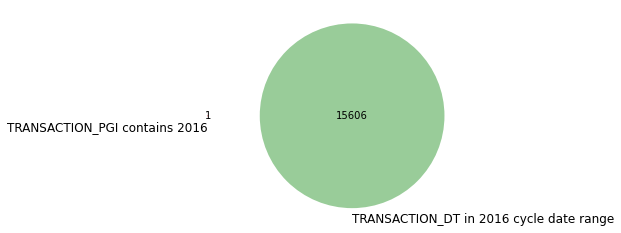

In [17]:
# Use the venn2 function
venn2(subsets = (1, 15606, 0), set_labels = ('TRANSACTION_PGI contains 2016', 'TRANSACTION_DT in 2016 cycle date range'))
plt.show()

In [34]:
explicitly_incycle_data_additv2 = pd.concat([explicitly_incycle_data_addit, dates_in_2016cyc_fr2014])
# Drop duplicates from the concatenated dataset
explicitly_incycle_data_additv2.drop_duplicates(subset=['SUB_ID'], inplace=True)
explicitly_incycle_data_additv2

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI           IMAGE_NUM  \
284595  C90011578         N     Q3           G2016         14978174341   
88968   C00008086         A     YE               G         14960497814   
90630   C00468579         A     YE               G         14960866185   
113515  C00458463         A     Q2               G         13020322083   
220941  C00010421         A    30G               G         14953206796   
...           ...       ...    ...             ...                 ...   
570473  C00003418         A    30G             NaN  201510149002882039   
570477  C00003418         A    30G             NaN  201510149002882040   
570478  C00003418         A    30G             NaN  201510149002882041   
570487  C00003418         A    30G               P  201510149002881995   
570488  C00003418         A    30G               P  201510149002881996   

       TRANSACTION_TP ENTITY_TP                               NAME  \
284595            24E       ORG  NATIONAL MEDIA PUBLIC AFFAIRS LLC   
88968             15J       IND                         POOLE, LEE   
90630             15J       IND                    GOGUEN, MICHAEL   
113515            15J       IND                  TIMKEN, WARD J JR   
220941            24K       CCM                ROGERS FOR CONGRESS   
...               ...       ...                                ...   
570473            24C       ORG                 TARRANCE GROUP INC   
570477            24C       ORG               SMARTECH CORPORATION   
570478            24C       ORG               SMARTECH CORPORATION   
570487            24G       PTY              UTAH REPUBLICAN PARTY   
570488            24G       PTY      REPUBLICAN PARTY OF LOUISIANA   

                  CITY STATE  ...                EMPLOYER  \
284595      ALEXANDRIA    VA  ...                     NaN   
88968          BOZEMAN    MT  ...   MOONLIGHT BASIN RANCH   
90630        LOS ALTOS    CA  ...          PROOF RESEARCH   
113515          CANTON    OH  ...  THE TIMKEN CORPORATION   
220941        BRIGHTON    MI  ...                     NaN   
...                ...   ...  ...                     ...   
570473      ALEXANDRIA    VA  ...                     NaN   
570477     CHATTANOOGA    TN  ...                     NaN   
570478     CHATTANOOGA    TN  ...                     NaN   
570487  SALT LAKE CITY    UT  ...                     NaN   
570488     BATON ROUGE    LA  ...                     NaN   

                           OCCUPATION TRANSACTION_DT TRANSACTION_AMT  \
284595                            NaN       08072014        179987.0   
88968                           OWNER     2014-12-13          4500.0   
90630                        INVESTOR     2014-12-30           872.0   
113515  CHAIRMAN - BOARD OF DIRECTORS     2016-05-30          2600.0   
220941                            NaN     2014-11-13         -5000.0   
...                               ...            ...             ...   
570473                            NaN     2014-11-05         23218.0   
570477                            NaN     2014-11-12            31.0   
570478                            NaN     2014-11-12           176.0   
570487                            NaN     2014-11-12          5000.0   
570488                            NaN     2014-11-17        120000.0   

         OTHER_ID           TRAN_ID FILE_NUM MEMO_CD  \
284595  S6GA00119        F57.000002   956012     NaN   
88968         NaN  23064-177467-1-P   911788       X   
90630         NaN        SA12.19595   922444       X   
113515        NaN   SA0729115713316   882086       X   
220941  C00343863          22102386   980560     NaN   
...           ...               ...      ...     ...   
570473  S4NM00100  2014G30L25CE0206  1028330     NaN   
570477  H4OR05239  2014G30L25CE0210  1028330     NaN   
570478  S4OR00198  2014G30L25CE0211  1028330     NaN   
570487  C00089482   2014G30L2200725  1028330     NaN   
570488  C00187450   2014G30L2200787  1028330     NaN   

         

# 2016 Cycle Data from the 2015-2016 itoth data

In [19]:
data2016 = pd.read_csv(r"../raw data/oth16/itoth2016.txt", 
                    sep='|', header=None, names = colnm, dtype=coltypes)

In [20]:
print(data2016.shape)
data2016.head()

(2147537, 21)


CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM TRANSACTION_TP  \
0  C00548198         N     M3           G2016  15950887602            24K   
1  C00548198         N     M3           G2016  15950887602            24K   
2  C00235739         N     M3           P2015  15950887797            24K   
3  C00235739         N     M3           P2015  15950887797            24K   
4  C00235739         N     M3           P2015  15950887797            24K   

  ENTITY_TP                                               NAME  \
0       CCM                        KEVIN MCCARTHY FOR CONGRESS   
1       CCM                                BLAINE FOR CONGRESS   
2       PTY    DEMOCRATIC SENATORIAL CAMPAIGN CMTE - BLDG FUND   
3       PTY  NATIONAL REPUBLICAN CONGRESSIONAL CMTE - BLDG ...   
4       PTY    NATIONAL REPUBLICAN SENATORIAL CMTE - BLDG FUND   

             CITY STATE  ... EMPLOYER OCCUPATION TRANSACTION_DT  \
0     BAKERSFIELD    CA  ...      NaN        NaN       02112015   
1  JEFFERSON CITY    MO  ...      NaN        NaN       02102015   
2      WASHINGTON    DC  ...      NaN        NaN       02272015   
3      WASHINGTON    DC  ...      NaN        NaN       02272015   
4      WASHINGTON    DC  ...      NaN        NaN       02272015   

  TRANSACTION_AMT   OTHER_ID  TRAN_ID FILE_NUM MEMO_CD MEMO_TEXT  \
0          1000.0  C00420935  6788487   998835     NaN       NaN   
1          2500.0  C00458679  6783511   998835     NaN       NaN   
2          2500.0  C00042366  B546280   998836     NaN       NaN   
3          2500.0  C00075820  B546281   998836     NaN       NaN   
4          2500.0  C00027466  B546282   998836     NaN       NaN   

                SUB_ID  
0  4032020151240895092  
1  4032020151240895091  
2  4032020151240895114  
3  4032020151240895115  
4  4032020151240895116  

[5 rows x 21 columns]

In [21]:
cy16fr16 = data2016[data2016['TRANSACTION_PGI'].str.contains("2016", na=False)]
cy16fr16.shape

(1601790, 21)

In [23]:
## Find 1016-01-02
data2016[data2016['TRANSACTION_DT'].str.contains("....1016", na=False)]

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI           IMAGE_NUM  \
2054471  C00597716         N     YE               G  201702090300140697   
2054472  C00597716         N     YE               G  201702090300140697   
2054473  C00597716         N     YE               G  201702090300140697   

        TRANSACTION_TP ENTITY_TP               NAME   CITY STATE  ...  \
2054471            20C       IND   WESTLEY, TIMMY L  SELMA    TX  ...   
2054472            20C       IND   WESTLEY, TIMMY L  SELMA    TX  ...   
2054473            20C       IND  WESTLEY, TI MMY L  SELMA    TX  ...   

        EMPLOYER OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  \
2054471      NaN        NaN       01021016         20069.0  H6TX15204   
2054472      NaN        NaN       01021016             0.0  H6TX15204   
2054473      NaN        NaN       01021016             0.0  H6TX15204   

                TRAN_ID FILE_NUM MEMO_CD MEMO_TEXT               SUB_ID  
2054471  SB021317069748  1148621     NaN       NaN  2021320171370701317  
2054472  SB021317069749  1148621     NaN       NaN  2021320171370701318  
2054473  SB021317069750  1148621     NaN       NaN  2021320171370701319  

[3 rows x 21 columns]

Ahh okay I see, so there are three rows that are supposedly from January 2nd, 1016 - which is clearly nonsensical. This was probably a typo where someone typed 1016 instead of 2016
Improvement idea 1) c) ii) I will validate the ground truth by finding the original filing.
For now, I will get rid of these rows, then convert it to a date.

In [24]:
data2016 = data2016[~data2016['TRANSACTION_DT'].str.contains("....1016", na=False)]
data2016.shape

(2147534, 21)

In [25]:
data2016[['TRANSACTION_DT']] = pd.to_datetime(data2016['TRANSACTION_DT'], format='%m%d%Y').dt.date
data2016[['TRANSACTION_DT']]

TRANSACTION_DT
0           2015-02-11
1           2015-02-10
2           2015-02-27
3           2015-02-27
4           2015-02-27
...                ...
2147532     2016-08-22
2147533     2016-08-16
2147534     2016-08-16
2147535     2016-08-12
2147536     2016-08-16

[2147534 rows x 1 columns]

In [27]:
#greater than the start date and smaller than the end date
mask = (data2016['TRANSACTION_DT'] >= start2016cyc) & (data2016['TRANSACTION_DT'] <= end2016cyc)
dates_in_2016cyc_fr2016 = data2016.loc[mask]
dates_in_2016cyc_fr2016.shape

Hmm, how many of the 989,436 records I found contain 2020 in the transaction_pgi? What does the venn diagram look like with transaction_pgi containing 2020? How many are both? How many are just in the date range? How many just contain 2020 in transaction_pgi?

In [28]:
pd.merge(left=cy16fr16, right=dates_in_2016cyc_fr2016, left_on='SUB_ID', right_on='SUB_ID').shape

(1590095, 41)

In [32]:
1601790+2116680-1590095

2128375

So there are 1590095 records that are in both,
And since there were 1601790 records that contained 2016 in its transaction_pgi, 
that means that there are 1601790-1590095 = 11695 records that weren't in the date range but did contain 2020 in the transaction_pgi.
And since there were 2116680 rows that were in the date range, 
there were 2116680-1590095= 526585 records that were in the 2016 cycle date range but didn't have transaction_pgi containing 2020. <br>
There should be 1601790+2116680-1590095 = 2128375 rows in the dataframe consisting of 2016 cycle transactions from the 2015-2016 itoth file.

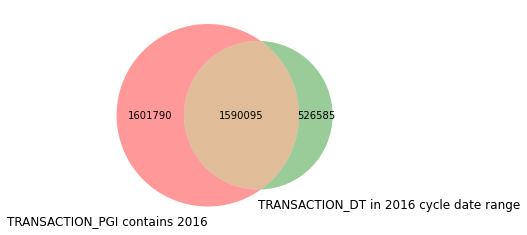

In [33]:
# Use the venn2 function
venn2(subsets = (1601790, 526585, 1590095), set_labels = ('TRANSACTION_PGI contains 2016', 'TRANSACTION_DT in 2016 cycle date range'))
plt.show()
# I wonder what is the transaction_dt range and distribution for records where transaction_pgi contains 2020, and how far off it is from the 2020 election cycle.
    # Improvement idea 2) b) Investigate this to see if it can help me get the correct dates.

In [36]:
cy16fr16v2 = pd.concat([cy16fr16, dates_in_2016cyc_fr2016])
# Drop duplicates from the concatenated dataset
cy16fr16v2.drop_duplicates(subset=['SUB_ID'], inplace=True)

In [37]:
# First, vertically concatenate the two dataframes
# then save the result to a csv
# check the number of rows in cy18fr16 and cy18fr18
print('Shape for 2016 election cycle transactions from 2014: ', str(explicitly_incycle_data_additv2.shape))
print('Shape for 2016 election cycle transactions from 2016: ', str(cy16fr16v2.shape))
print('There should be', explicitly_incycle_data_additv2.shape[0]+cy16fr16v2.shape[0], 'rows total for 2016 election cycle transactions.' )

Shape for 2016 election cycle transactions from 2014:  (15607, 21)
Shape for 2016 election cycle transactions from 2016:  (2128375, 21)
There should be 2143982 rows total for 2016 election cycle transactions.


In [38]:
fec_cy2016 = pd.concat([explicitly_incycle_data_additv2, cy16fr16v2], ignore_index=True)
fec_cy2016

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI           IMAGE_NUM  \
0        C90011578         N     Q3           G2016         14978174341   
1        C00008086         A     YE               G         14960497814   
2        C00468579         A     YE               G         14960866185   
3        C00458463         A     Q2               G         13020322083   
4        C00010421         A    30G               G         14953206796   
...            ...       ...    ...             ...                 ...   
2143977  C00161786         A    30G               P  201705179053949007   
2143978  C00161786         A    30G               P  201705179053949007   
2143979  C90016650         A     YE               G  201701230300132310   
2143980  C90008236         A     YE               G  201702010300137124   
2143981  C90009390         N     YE               G  201702010300137461   

        TRANSACTION_TP ENTITY_TP  \
0                  24E       ORG   
1                  15J       IND   
2                  15J       IND   
3                  15J       IND   
4                  24K       CCM   
...                ...       ...   
2143977            18J       PAC   
2143978            18J       PAC   
2143979            24E       NaN   
2143980            24A       NaN   
2143981            24A       NaN   

                                                      NAME         CITY STATE  \
0                        NATIONAL MEDIA PUBLIC AFFAIRS LLC   ALEXANDRIA    VA   
1                                               POOLE, LEE      BOZEMAN    MT   
2                                          GOGUEN, MICHAEL    LOS ALTOS    CA   
3                                        TIMKEN, WARD J JR       CANTON    OH   
4                                      ROGERS FOR CONGRESS     BRIGHTON    MI   
...                                                    ...          ...   ...   
2143977                        WOMEN'S POLITICAL COMMITTEE  LOS ANGELES    CA   
2143978  COMMITTEE FOR HISPANIC CAUSES/BUILDING OUR LEA...   WASHINGTON    DC   
2143979                               TRYON DAILY BULLETIN          NaN    NC   
2143980                               RED HORSE STRATEGIES     BROOKLYN    NY   
2143981                               RED HORSE STRATEGIES     BROOKLYN    NY   

         ...                EMPLOYER                     OCCUPATION  \
0        ...                     NaN                            NaN   
1        ...   MOONLIGHT BASIN RANCH                          OWNER   
2        ...          PROOF RESEARCH                       INVESTOR   
3        ...  THE TIMKEN CORPORATION  CHAIRMAN - BOARD OF DIRECTORS   
4        ...                     NaN                            NaN   
...      ...                     ...                            ...   
2143977  ...                     NaN                            NaN   
2143978  ...                     NaN                            NaN   
2143979  ...                     NaN                            NaN   
2143980  ...                     NaN                            NaN   
2143981  ...                     NaN                            NaN   

        TRANSACTION_DT TRANSACTION_AMT   OTHER_ID           TRAN_ID FILE_NUM  \
0             08072014        179987.0  S6GA00119        F57.000002   956012   
1           2014-12-13          4500.0        NaN  23064-177467-1-P   911788   
2           2014-12-30           872.0        NaN        SA12.19595   922444   
3           2016-05-30          2600.0        NaN   SA0729115713316   882086   
4           2014-11-13         -5000.0  C00343863          22102386   980560   
...                ...             ...        ...               ...      ...   
2143977     2016-09-30           789.0  C00188193     11C-000238708  1162775   
2143978     2016-09-13           921.0  C00365536     11C-000237571  1162775   
2143979     2016-10-19           108.0        NaN    F5701251723101  1141096   
2143980     2016-10-27          2222.0        NaN  

Now that I have the itoth data from the 2016 election cycle, I'm going to extract it to the relevant records, which is those with (transaction_tp = '24Z') and (entity_tp<>'IND' or entity_tp is null). <br>
Then, I will extract the first digits of the transaction amounts into their own column.

In [39]:
fec_cy2016_ctc = fec_cy2016[(fec_cy2016["TRANSACTION_TP"]=='24Z') & ((fec_cy2016["ENTITY_TP"]!='IND') | (fec_cy2016["ENTITY_TP"].isnull()))] 

In [40]:
# Extract the first digits of transaction_amt
fec_cy2016_ctc = fec_cy2016_ctc.assign(amt_firstdig=fec_cy2016_ctc['TRANSACTION_AMT'].astype(str).str[:1].values)
fec_cy2016_ctc[['TRANSACTION_AMT', 'amt_firstdig']]

TRANSACTION_AMT amt_firstdig
108               1803.0            1
111               1022.0            1
112                300.0            3
113               1082.0            1
114                901.0            9
...                  ...          ...
2108448           5400.0            5
2108449          10800.0            1
2127662          20025.0            2
2127665           1353.0            1
2127666           3032.0            3

[5276 rows x 2 columns]

In [41]:
# drop those where transaction_amt not in [1,9], eg. if it's 0 or negative
firstdigitslist = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
fec_cy2016_ctc = fec_cy2016_ctc[fec_cy2016_ctc['amt_firstdig'].isin(firstdigitslist)]

In [42]:
if save_result == 1:
    fec_cy2016_ctc.to_csv('FEC-itoth-2016cycle-ctc-inkind.csv', sep = '|', index = False)